# <center> UK and US elections code

We import the requested modules and set up some parameters for the plots appearance.

In [8]:
# imports
import re
import sys
import pickle
import numpy as np
import pandas as pd
from time import time
from scipy.linalg import expm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import text as Text
from matplotlib.lines import Line2D
from matplotlib import rc

# for plots appearance
gov_color = {"Con":"blue", "Lab":"red", "Nat":"orange", "Coa":"green", "?":"black"}
party_color = {"con":"blue", "lab":"red", "rep":"red", "dem":"blue"}
party_color2 = {"con":"darkblue", "lab":"maroon", "dem":"darkblue", "rep":"maroon"}
ls = {"con":":", "lab":"--", "dem":":", "rep":"--"}
mark = {"con":"d", "lab":"o", "dem":"o", "rep":"d"}

# latex rendering
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
rc('text', usetex=True)

First we create a useful function to compute a transition rate matrix Q using our voter model based on the values of n,s0,s1.

In [9]:
def Q_matrix(n,s0,s1):
    q = np.zeros((n-s0-s1+1, n-s0-s1+1))
    for k in range(s1,n-s0+1):
        q[k-s1,k-s1-1] = (k-s1)*(n-k)/(n-1)
        if k < n-s0:
            q[k-s1,k-s1+1] = k*(n-k-s0)/(n-1)
        q[k-s1,k-s1] = - (k-s1)*(n-k)/(n-1) - k*(n-k-s0)/(n-1)
    return q

Parameters. Choose the region (UK or US).

In [11]:
n = 100 # nb users
region = "us" # uk or us

Get parties names.

In [12]:
if region == "uk":
    parties= ("con", "lab")
    party_name = {"con":"Conservative", "lab":"Labour"}
if region == "us":
    parties = ("rep", "dem") 
    party_name = {"rep":"Republicans", "dem":"Democrats"} 

Load dataset and preprocess.

In [15]:
############ UNITED KINGDOM ############
if region == "uk":
    # nb seats for each party
    X = dict()
    for p in parties:
        df = pd.read_csv("../data/uk_elections/vote_shares/{}_results.csv".format(region))
        x  = np.array(df[p])
        X[p] = np.around(x).astype(int)

    # time
    year = np.array(df["year"])
    year = np.append(year, 2024) # add next election
    T = (year-year[0]).astype(float)
    T[15:] += 0.5

    # nb datapoints
    length = df.shape[0]

############ UNITED STATES ############
if region=="us":
    year = np.array([],dtype=int)
    X = {p: np.array([],dtype=int) for p in parties}
    for line in open("../data/us_elections/1912to1972_raw.txt"):
        if "United States Presidential Election" in line:
            year = np.append(year, int(line[:4]))
            done = {p:False for p in parties}
        if "Republican" in line:
            p = "rep"
        elif "Democratic" in line:
            p = "dem"
        else:
            continue
        x = re.search(r"\d*\.*\d*\%", line)
        x = round(float(x.group()[:-1]))
        if not done[p]:
            X[p] = np.append(X[p],x)
            done[p] = True
        else:
            X[p][-1] += x

    # create timeline, get length
    year = np.append(year,2020)
    T = (year-year[0]).astype(float)
    length = T.size-1

Each election year, we estimate (s0,s1) for Con and Lab based on all the previous results.

In [ ]:
estimate = {p:list() for p in parties}
start = time()

for j in range(2, length+1): # new estimates for each datapoint
    
    for p in parties: # for each party
        
        xbar_tmp = X[p][:j].mean()
        s1_max = X[p][:j].min()
        current_max, best_estim = None, None
        count = 0

        for s1 in range(1, s1_max+1): # check all possible values of s1
            s0_max = n-X[p][:j].max()
            #s0 = int(min(s0_max, round((n/xbar[p]-1)*s1)))
            for s0 in range(1, s0_max+1): # check all possible values of s0

                # print status
                count += 1
                sys.stdout.flush()
                sys.stdout.write("Datapoint {}/{} ...... {} ...... (s0,s1) test {}/{} ...... elapsed time {} ...............\r"
                                 .format(j, length, p, count, s1_max*s0_max, time()-start))

                # compute Q
                Q = Q_matrix(n,s0,s1)

                # compute log likelihood
                log_likelihood = 0
                for i in range(1, j):
                    t = T[i] - T[i-1]
                    x, y = X[p][i-1], X[p][i]
                    log_likelihood += np.log(expm(t*Q)[x-s1, y-s1])

                # update max if better
                if current_max == None:
                    current_max, best_estim = log_likelihood, (s0,s1)
                elif log_likelihood > current_max:
                    current_max, best_estim = log_likelihood, (s0,s1)

        # append best estim to S0 and S1 dicts
        estimate[p].append(best_estim)

Show results.

In [366]:
print("Year | {} | {}".format(parties[0], parties[1]))
for i in range(length-1):
    print(year[2:][i], estimate[parties[0]][i], estimate[parties[1]][i])

Year | rep | dem
1920 (23, 23) (44, 42)
1924 (15, 21) (18, 12)
1928 (18, 23) (15, 8)
1932 (18, 23) (18, 11)
1936 (16, 18) (10, 8)
1940 (13, 13) (7, 7)
1944 (14, 14) (9, 8)
1948 (15, 15) (9, 8)
1952 (17, 16) (10, 9)
1956 (16, 16) (11, 10)
1960 (16, 16) (11, 10)
1964 (17, 17) (12, 11)
1968 (17, 16) (10, 10)
1972 (17, 16) (12, 11)
1976 (15, 15) (11, 10)
1980 (16, 16) (12, 11)
1984 (16, 16) (13, 11)
1988 (16, 16) (13, 11)
1992 (16, 16) (14, 12)
1996 (15, 15) (14, 12)
2000 (16, 15) (15, 13)
2004 (16, 15) (15, 13)
2008 (16, 16) (15, 13)
2012 (17, 16) (16, 14)
2016 (17, 16) (16, 14)
2020 (18, 17) (16, 14)


Now we compute the predicted distributions, each time based on the most recent estimate of s0,s1.

In [367]:
jump_distrib = {p:list() for p in parties}
maximum = 0
Mean, Std = {p:list() for p in parties}, {p:list() for p in parties}
Max = {p:list() for p in parties}

for p in parties:
    
    jump_distrib[p] = list()
    
    for i in range(2,length+1):
        
        # compute Q but only if it's the first time or s0,s1 are different than last time
        s0,s1 = estimate[p][i-2]
        Q = Q_matrix(n,s0,s1)
            
        # predict distribution
        t = T[i] - T[i-1]
        x = X[p][i-1]
        density = expm(t*Q)[x-s1,:]
        jump_distrib[p].append(density)
        maximum = max(maximum, density.max())
        
        # mean and std and max
        mean = np.arange(s1,n-s0+1).dot(density)
        Mean[p].append(mean)
        Std[p].append(np.sqrt((np.arange(s1,n-s0+1)**2).dot(density) - mean**2))
        Max[p].append(np.argmax(density)+s1)
        
    # convert to array    
    jump_distrib[p] = np.array(jump_distrib[p])

Now compare the mean with outcomes over time on a single plot.

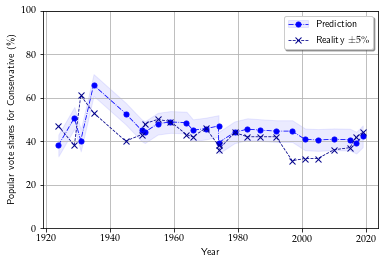

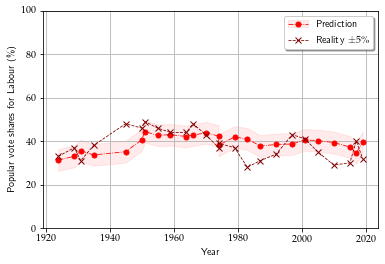

In [334]:
Mean = {p: np.array(Mean[p]) for p in parties}
Std = {p: np.array(Std[p]) for p in parties}

for p in parties:
            
    color = party_color[p]
    color2 = party_color2[p]
    
    # plot
    plt.grid()
    fill = plt.fill_between(year[2:-1],  Mean[p][:-1]-5,  Mean[p][:-1]+5, color=color, alpha=.08)
    pred, = plt.plot(year[2:-1], Mean[p][:-1], marker="o", markersize=5, ls="-.", linewidth=.8, color=color)
    real, = plt.plot(year[2:-1], X[p][2:], marker="x", ls="--", linewidth=.8, color=color2)
    #plt.fill_between(year[2:-1], Mean[p][:-1]-Std[p][:-1], Mean[p][:-1]+Std[p][:-1], color="green", alpha=.1)

    # legend and axes lim
    elements = [(fill,pred), real]
    names = ["Prediction", r"Reality $\pm 5\%$"]
    plt.legend(elements, names, loc="best", shadow=True)
    plt.ylim(0,100)
    
    # show and save
    plt.xlabel("Year")
    plt.ylabel("Popular vote shares for {} (\%)".format(party_name[p]))
    plt.savefig("pred_vs_real_{}_{}.pdf".format(region,p))
    plt.show()
    plt.close()

Now we quantify the distance between the actual outcome and the mean of the theoretical distribution.

In [374]:
gap = {p: np.array([]) for p in parties}
gap_run = {p: np.array([]) for p in parties}
stddev = {p: np.array([]) for p in parties}
window = 5 # window size for running averages

for p in parties:
    for i in range(2,length):
        s0, s1 = estimate[p][i-2]
        datapoint = X[p][i]
        density = jump_distrib[p][i-2]
        
        # gap
        g = np.abs(datapoint-Mean[p][i-2]) # normal line
        #g = np.abs(datapoint-X[p][i-1]) # to test when we predict the last result exactly
        gap[p] = np.append(gap[p], g)
        
        # gap running average
        if i-2<window:
            gap_run[p] = np.append(gap_run[p], gap[p].mean())
        else:
            gap_run[p] = np.append(gap_run[p], gap[p][i-2-window+1:i+1].mean())
        
        # std dev
        stddev[p] = np.append(stddev[p], g/Std[p][i-2])

Then we plot.

rep,0.10334519504053219,16.460533224644664,5.77667284669645,4.274465614194938
dem,0.04388322269425515,18.118094288696284,5.8634384983837915,4.58971054142404


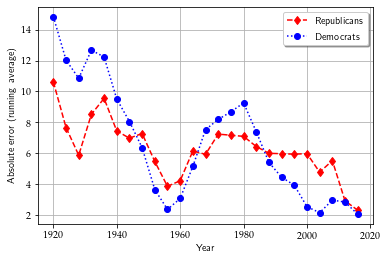

In [375]:
# open file
gap_file = open("../results/{}_gap.txt".format(region), "w")
gap_file.write("party,min,max,mean,med\n")
plt.grid() 

# plot
for p in parties:
    string = "{},{},{},{},{}".format(p, gap[p].min(), gap[p].max(), gap[p].mean(), np.median(gap[p]))
    print(string)
    gap_file.write(string+"\n")
    #plt.plot(year[2:-1], gap[p], marker=mark[p], color=party_color[p], ls=ls[p], lw=.5, label=party_name[p])
    plt.plot(year[2:-1], gap_run[p], color=party_color[p], ls=ls[p], marker=mark[p], label=party_name[p])

# legend and labels
plt.legend(loc="best", shadow=True)
plt.xlabel(r"Year")
plt.ylabel(r"Absolute error (running average)")

# save and show
plt.savefig("{}_evolve_gap.pdf".format(region))
plt.show()
plt.close()
gap_file.close()

Basic statistics after model calibration. We choose the starting year.

In [378]:
if region == "uk":
    start = 9
if region =="us":
    start = 5
for p in parties:
    gap_tmp = gap[p][start:]
    print(p)
    print("min", gap_tmp.min(), year[np.argmin(gap_tmp)+start+2])
    print("max", gap_tmp.max(), year[np.argmax(gap_tmp)+start+2])
    print("mean", gap_tmp.mean())
    print()

rep
min 0.10334519504053219 1940
max 13.960941878756351 1972
mean 4.832128278186608

dem
min 0.04388322269425515 2016
max 12.315580899143782 1964
mean 4.271102937342438

